In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
import sklearn
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.colors as colors
import pandas as pd
import openpyxl
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
from shapely.geometry import Point, Polygon



xr.__version__

'0.17.0'

In [2]:
pwd

'C:\\Users\\s2113022\\Documents\\PhD\\DATA\\UK_SMARTBUOY'

In [3]:
#Uploading Satellite data

file = Path('../../DATA/UK_SMARTBUOY/SatS2/','satDowsS2.csv') 
satDows = pd.read_csv(file)


file = Path('../../DATA/UK_SMARTBUOY/SatS2/','satLivBayS2.csv') 
satLivS2 = pd.read_csv(file)

file = Path('../../DATA/UK_SMARTBUOY/SatS2/','satThamesS2.csv') 
satThamesS2 = pd.read_csv(file)

file = Path('../../DATA/UK_SMARTBUOY/SatS2/','satWGabS2.csv') 
satWGabS2 = pd.read_csv(file)



In [88]:
# # Uploading initu of WestGab then making into a complete one together. 

# file3 = Path('../../DATA/UK_SMARTBUOY/','In-situ/WESTGAB_20160510.csv') # first = path to notebook, 2nd = to file
# insituWGab16 = pd.read_csv(file3)

# file3 = Path('../../DATA/UK_SMARTBUOY/','In-situ/WESTGAB2_20201023.csv') # first = path to notebook, 2nd = to file
# insituWGab20 = pd.read_csv(file3)

# #converting the datetime from type object to datetime 
# insituWGab20['DateTime'] = pd.to_datetime(insituWGab20['DateTime'])
# # then converting the date string into same as other insitu
# insituWGab20['DateTime'] = insituWGab20['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
# #both Wgab in-situ
# insituWGab = pd.concat([insituWGab16,insituWGab20])
# insituWGab

# insituWGab.to_csv(r'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/insituWGAb.csv')


In [91]:

file2 = Path('../../DATA/UK_SMARTBUOY/','In-situ/DOWSING_20190514.csv') # first = path to notebook, 2nd = to file
insituDows = pd.read_csv(file2)

file3 = Path('../../DATA/UK_SMARTBUOY/','In-situ/TH1_20200702.csv') # first = path to notebook, 2nd = to file
insituThames = pd.read_csv(file3)

file3 = Path('../../DATA/UK_SMARTBUOY/','In-situ/LIVBAY_20200930.csv') # first = path to notebook, 2nd = to file
insituLiv = pd.read_csv(file3)

file3 = Path('../../DATA/UK_SMARTBUOY/','In-situ/insituWGAb.csv') # first = path to notebook, 2nd = to file
insituWGab = pd.read_csv(file3)




## Getting readable Datetime format

In [37]:
import ee
import numpy as np
import pandas as pd
import os

## Trigger the authentication flow.
ee.Authenticate()

## Initialise the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWhrK5ioyF3JxwtZh4oPL6D3tzMzamRYvj8u0oy540d_CMbsJhDGeaA

Successfully saved authorization token.


# Adding Lat/Lon to Satellite data

In [81]:
def addinglat_lon2sat(lat,lon,satDows): # takes lat,lon and the satellite dataframe as input

#lat = 53.53133
#lon = 1.053167

    lat = [lat]*499
    lon = [lon]*499
    lat = pd.Series(lat)     #making series for datafram
    lat = lat.rename("LATITUDE") #naming series

    lon = pd.Series(lon)
    lon = lon.rename("LONGITUDE")

    satDows.insert(1,"LATITUDE",lat,True) #(adds cluster at column 1)
    satDows.insert(1,"LONGITUDE",lon,True) #(adds cluster at column 1)
    
    return satDows #returns an sat df with lat/lon added in


In [82]:
# Adding all locations to satellite data
satLivS2 = addinglat_lon2sat(53.531833,-3.367833,satLivS2)
satThamesS2 = addinglat_lon2sat(51.52650,1.029700,satThamesS2) 
satWGabS2 = addinglat_lon2sat(51.954583,2.109600,satWGabS2)
satDows = addinglat_lon2sat(53.531333,1.053167,satDows)


In [38]:
print(satLivS2.iloc[0,28] # checking date is in right column)
#satDows.iloc[0,5] # testing for the converting datetime! 

date = ee.Date(int(satDows.iloc[168,28])).format().getInfo()
# making timestamp into readable date (int->format-> get info)
date

'2018-03-20T11:04:36'

# Converting all datetime of dataframe:

In [84]:
def convertDTindexintodatetime(satDows):

    datetime = []

    for i in range(0,satDows.shape[0]):
        a = satDows.iloc[i,28]
    
        date_i = ee.Date(int(a)).format().getInfo() # making timestamp into readable date (int->format-> get info)
        datetime.append(date_i)


    datetime = pd.Series(datetime)
    datetime = datetime.rename("TIMEDATE")

    satDows.insert(1,"TIMEDATE",datetime,True) #(adds new date/time at column 3)

    satDows.loc[100,'TIMEDATE'] #testing at random time

    return satDows

In [85]:
satLivS2 = convertDTindexintodatetime(satLivS2)
satDows = convertDTindexintodatetime(satDows)
satWGabS2= convertDTindexintodatetime(satWGabS2)
satThamesS2 = convertDTindexintodatetime(satThamesS2)

satLivS2

,Unnamed: 0,TIMEDATE,LONGITUDE,LATITUDE,AOT,B1,B11,B12,B2,B3,...,SOLAR_IRRADIANCE_B2,SOLAR_IRRADIANCE_B3,SOLAR_IRRADIANCE_B4,SOLAR_IRRADIANCE_B5,SOLAR_IRRADIANCE_B6,SOLAR_IRRADIANCE_B7,SOLAR_IRRADIANCE_B8,SOLAR_IRRADIANCE_B8A,SOLAR_IRRADIANCE_B9,system_index
0,0,2017-04-08T11:34:07,-3.367833,53.531833,168.0,304.654717,1.000000,1.600000,223.515094,184.243396,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170408T113321_20170408T113407_T30UVE
1,1,2017-04-15T11:25:15,-3.367833,53.531833,228.0,33.079245,64.477358,63.183019,154.507547,242.684906,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170415T112111_20170415T112515_T30UVE
2,2,2017-04-18T11:34:13,-3.367833,53.531833,264.0,501.141509,62.337736,60.886792,471.477358,440.884906,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170418T113321_20170418T113413_T30UVE
3,3,2017-04-25T11:21:15,-3.367833,53.531833,168.0,10251.575472,5066.409434,3842.175472,8990.315094,8135.613208,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170425T112121_20170425T112115_T30UVE
4,4,2017-04-28T11:34:00,-3.367833,53.531833,204.0,10627.845283,4954.864151,3282.905660,9575.564151,8897.443396,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170428T113321_20170428T113400_T30UVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,535,2021-05-02T11:36:18,NaN,NaN,144.0,7568.309434,4710.586792,4616.205660,7178.269811,6543.794340,...,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,20210502T113319_20210502T113315_T30UVE
536,536,2021-05-04T11:26:23,NaN,NaN,204.0,4206.205660,1565.871698,1498.133962,3969.162264,3685.735849,...,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,20210504T112111_20210504T112445_T30UVE
537,537,2021-05-07T11:36:20,NaN,NaN,114.0,485.454717,444.262264,314.556604,662.584906,605.062264,...,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,20210507T113321_20210507T113448_T30UVE
538,538,2021-05-09T11:26:22,NaN,NaN,120.0,8593.471698,2755.560377,2527.849057,8410.877358,7990.052830,...,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,20210509T112109_20210509T112111_T30UVE


In [42]:
### Getting the temp/salinity in-situ in separate columns.  
def seperating_tempsal(insituDows):

    lat = []
    lon =[]
    DT = []
    temp = []
    sal = []


    for i in range(0,(insituDows.shape[0])):


        
        if insituDows.loc[i, 'parameter'] == 'TEMP' :   

            temp.append(insituDows.loc[i, 'value'])
            lat.append(insituDows.loc[i,'latitude'])
            lon.append(insituDows.loc[i,'longitude'])
            DT.append(insituDows.loc[i,'DateTime'])
            sal.append(0)


        if insituDows.loc[i, 'parameter'] == 'SAL':

            sal.append(insituDows.loc[i, 'value'])
            lat.append(insituDows.loc[i,'latitude'])
            lon.append(insituDows.loc[i,'longitude'])
            DT.append(insituDows.loc[i,'DateTime'])
            temp.append(0)



    #Converting all lists to Dataframes
    temp_df = pd.DataFrame(temp ,columns=['Temperature'])
    sal_df = pd.DataFrame(sal ,columns=['Salinity'])
    lat_df = pd.DataFrame(lat ,columns=['Latitude'])
    lon_df = pd.DataFrame(lon ,columns=['Longitude'])
    dateandtime_df = pd.DataFrame(DT ,columns=['DateandTime'])


    InsituDows2 =  pd.concat([lat_df,lon_df,dateandtime_df,temp_df,sal_df], axis=1)
    return InsituDows2



In [99]:
def mergingzerorowstempsal(InsituDows2):
    # Merging the zero rows of temp and salinity
    lat = []
    lon =[]
    DT = []
    temp = []
    sal = []


    for i in range(0,InsituDows2.shape[0]-1):
        if InsituDows2.iloc[i,2] == InsituDows2.iloc[i+1,2] and (InsituDows2.iloc[i,3] == 0 or InsituDows2.iloc[i+1,3] == 0):
            temp.append(max((InsituDows2.loc[i, 'Temperature'],InsituDows2.loc[i+1, 'Temperature'])))
            lat.append(InsituDows2.loc[i,'Latitude'])
            lon.append(InsituDows2.loc[i,'Longitude'])
            DT.append(InsituDows2.loc[i,'DateandTime'])
            sal.append(max((InsituDows2.loc[i, 'Salinity'],InsituDows2.loc[i+1, 'Salinity'])))
            i= i +1;




        else:
            lat.append(InsituDows2.loc[i,'Latitude'])
            lon.append(InsituDows2.loc[i,'Longitude'])
            DT.append(InsituDows2.loc[i,'DateandTime'])
            sal.append(InsituDows2.loc[i, 'Salinity'])
            temp.append(InsituDows2.loc[i,'Temperature'])



    #Converting all lists to Dataframes
    temp_df = pd.DataFrame(temp ,columns=['Temperature'])
    sal_df = pd.DataFrame(sal ,columns=['Salinity'])
    lat_df = pd.DataFrame(lat ,columns=['Latitude'])
    lon_df = pd.DataFrame(lon ,columns=['Longitude'])
    dateandtime_df = pd.DataFrame(DT ,columns=['DateandTime'])


    InsituDows2 =  pd.concat([lat_df,lon_df,dateandtime_df,temp_df,sal_df], axis=1)
    InsituDows2

    #downsampling to remove the repeated values/ zeros
    InsituDows2 = InsituDows2.iloc[::3, :]
    InsituDows2 = InsituDows2.reset_index(drop=True)
    
    return InsituDows2


In [100]:
# insituDows = seperating_tempsal(insituDows)
# insituLiv = seperating_tempsal(insituLiv)
# insituThames = seperating_tempsal(insituThames)
# insituWGab = seperating_tempsal(insituWGab)

#merging the rows of redundant data
insituDows = mergingzerorowstempsal(insituDows)
insituLiv = mergingzerorowstempsal(insituLiv)
insituThames = mergingzerorowstempsal(insituThames)
insituWGab = mergingzerorowstempsal(insituWGab)
insituWGab

,Latitude,Longitude,DateandTime,Temperature,Salinity
0,51.998167,2.079333,2002-08-28 13:15:00,18.78,34.69
1,51.998167,2.079333,2002-08-28 13:30:00,18.77,0.00
2,51.998167,2.079333,2002-08-28 14:00:00,18.75,34.64
3,51.998167,2.079333,2002-08-28 14:15:00,0.00,34.63
4,51.998167,2.079333,2002-08-28 14:45:00,18.74,34.61
...,...,...,...,...,...
231535,51.953650,2.111433,2020-10-23 20:00:00,14.59,0.00
231536,51.953650,2.111433,2020-10-23 20:30:00,14.60,0.00
231537,51.953650,2.111433,2020-10-23 21:30:00,14.57,0.00
231538,51.953650,2.111433,2020-10-23 22:00:00,14.59,0.00


## Plotting In-situ Temp vs Time

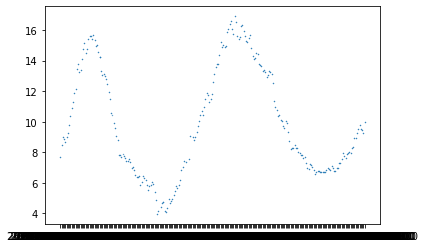

<Figure size 1080x576 with 0 Axes>

In [47]:
InsituDows2
ax = plt.axes()
fig = plt.figure(figsize=(15, 8))

DateTime = MatchedInsitu['DateandTime']
Temp = MatchedInsitu['Temperature']

ax.scatter(DateTime, Temp, s=0.1)

# Matching Data: 

In [214]:
def matchingdata(satDows,InsituDows2): # taking as inputs Sat/Insitu
#taking closest time_diff in-situ matches for each reflectance point so just have one match
    import datetime
    margin = datetime.timedelta(hours=1) #datetime allowed hour difference
    begin_time = datetime.datetime.now()

    #Make empty lists which will apped match values to:
    temp = []
    sal = []
    DT =[]
    lat = []
    lon = []


    SatMatched = satDows.columns.values # Rrs column titles 

    for i in range(0,satDows.shape[0]):       #iterate throough rows of Satellite

        time_diff_list = []
        n_matched = []


        #print(i)
        
        if InsituDows2.equals(insituWGab): #thames data had milisecond sin middle 
            
            for n in range(163933,InsituDows2.shape[0]-1): # rows of in-situ non-zero start (longer timeseries)
                # this is where matching...
                #insiturow = TempSal.iloc[n,:] 
                #print(n)

                #converting string to datetime      
                day = (satDows.iloc[i,1])
                datesat = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S')

                day2 = (InsituDows2.iloc[n,2])
                dateinsitu = datetime.datetime.strptime(day2,'%Y-%m-%d %H:%M:%S')

                #Difference intime between in-situ and Reflectance values 
                time_diff = abs(dateinsitu - datesat)
                #If matching location and time save temp, sal etc and RRS values
                if time_diff <= margin :#/
                    # code that inputs those matched values into dateframe df

                    n_matched.append(n)
                    time_diff_list.append(time_diff) #appending matched values to the list

            
        else:  
            for n in range(0,InsituDows2.shape[0]-1): # rows of in-situ non-zero start (longer timeseries)
                # this is where matching...
                #insiturow = TempSal.iloc[n,:] 
                #print(n)

                #converting string to datetime      
                day = (satDows.iloc[i,1])
                datesat = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S')

                day2 = (InsituDows2.iloc[n,2])
                dateinsitu = datetime.datetime.strptime(day2,'%Y-%m-%d %H:%M:%S')

                #Difference intime between in-situ and Reflectance values 
                time_diff = abs(dateinsitu - datesat)
                #If matching location and time save temp, sal etc and RRS values
                if time_diff <= margin :#/
                    # code that inputs those matched values into dateframe df

                    n_matched.append(n)
                    time_diff_list.append(time_diff) #appending matched values to the list


        time_diff_array = np.array(time_diff_list)
        n_matched_array = np.array(n_matched)        #making arrays of time_diff next to the row number 

        stacked = np.vstack((n_matched_array,time_diff_array))
        transposed = np.transpose(stacked)
        sortedArr = transposed[transposed[:,1].argsort()]  #sorting the array based on time
        #taking only the smallest 1 time differences. 
        top10rows = sortedArr[0:1,:]

        for m in top10rows[:,0]:        

            temp.append(InsituDows2.iloc[m,3])
            sal.append(InsituDows2.iloc[m,4])
            DT.append(InsituDows2.iloc[m,2])
            lon.append(InsituDows2.iloc[m,1])
            lat.append(InsituDows2.iloc[m,0])



            matchsat = satDows.iloc[i,:].to_numpy()
            SatMatched  = np.vstack((SatMatched,matchsat))

        #print('Length of Temp list =', len(temp))

        if i == 0: 
          #  print(datetime.datetime.now() - begin_time)

            print((datetime.datetime.now() - begin_time)*len(satDows)) #Estimating length of running code

    ### Satellite only run this once!!
    #Converting SatMatched array to DF, putting first row as column header then resseting index. 
    SatMatched = pd.DataFrame(SatMatched)
    SatMatched.columns = SatMatched.iloc[0]
    SatMatched = SatMatched.drop(SatMatched.index[0])
    SatMatched = SatMatched.reset_index(drop=True)


    # INSITU: Converting all lists to Dataframes 
    temp_df = pd.DataFrame(temp ,columns=['Temperature'])
    sal_df = pd.DataFrame(sal ,columns=['Salinity'])
    lat_df = pd.DataFrame(lat ,columns=['Latitude'])
    lon_df = pd.DataFrame(lon ,columns=['Longitude'])
    dateandtime_df = pd.DataFrame(DT ,columns=['DateandTime'])

    MatchedInsitu =  pd.concat([lat_df,lon_df,dateandtime_df,temp_df,sal_df], axis=1)


    MatchedInsituDows = MatchedInsitu


    #Moving the Lat/lon and Time columns to begining of Satellite dataframe
    first_column = SatMatched.pop('LATITUDE')
    SatMatched.insert(0,'LATITUDE',first_column,allow_duplicates = False)

    first_column = SatMatched.pop('LONGITUDE')
    SatMatched.insert(0,'LONGITUDE',first_column,allow_duplicates = False)
    first_column = SatMatched.pop('TIMEDATE')
    SatMatched.insert(0,'TIMEDATE',first_column,allow_duplicates = False)


    SatMatchedSal = pd.concat([sal_df,SatMatched], axis=1)
    SatMatchedTemp = pd.concat([temp_df,SatMatched], axis=1)


    #moving the sal/temp column from first to 3rd
    first_column = SatMatchedSal.pop('Salinity')
    SatMatchedSal.insert(3,'SALINITY',first_column,allow_duplicates = False)

    first_column = SatMatchedTemp.pop('Temperature')
    SatMatchedTemp.insert(3,'TEMPERATURE',first_column,allow_duplicates = False)
    
    return SatMatchedTemp,SatMatchedSal



In [21]:
#dropping unnamed:0 column 
# check the column index
SatMatchedTemp.columns[4]

'B12'

In [241]:
def TempSalDATAclean(SatMatchedTemp,SatMatchedSal):

    #dropping unnamed:0 column 
    # check the column index
    SatMatchedTemp.drop(SatMatchedTemp.columns[4], axis = 1, inplace = True)
    SatMatchedSal.drop(SatMatchedSal.columns[4], axis = 1, inplace = True)

#     #Downsampling to every other row (removing repeated values)
#     SatMatchedSal = SatMatchedSal.iloc[::2, :]
#     SatMatchedSal = SatMatchedSal.reset_index(drop=True)

#     #Downsampling to every other row (removing repeated values)
#     SatMatchedTemp = SatMatchedTemp.iloc[::2, :]
#     SatMatchedTemp = SatMatchedTemp.reset_index(drop=True)


    #Dropping columns with Nans (for modelling)
    SatMatchedTemp= SatMatchedTemp.dropna(axis=1)
    SatMatchedSal= SatMatchedSal.dropna(axis=1)

    # Now Making salinity/ temp values Nan from zero
    # take out as series then replace and add back in. 

    first_column = SatMatchedSal.pop('SALINITY')
    first_column = first_column.replace([0], np.nan)
    SatMatchedSal.insert(0,'SALINITY',first_column,allow_duplicates = False)

    first_column = SatMatchedTemp.pop('TEMPERATURE')
    first_column = first_column.replace([0], np.nan)
    SatMatchedTemp.insert(0,'TEMPERATURE',first_column,allow_duplicates = False)


    # Removing the rows with Temp/Sal Nan 
    SatMatchedTemp = SatMatchedTemp.dropna(axis=0)
    SatMatchedSal = SatMatchedSal.dropna(axis=0)

    return SatMatchedTemp,SatMatchedSal


In [212]:
import datetime

day2 = (insituWGab.iloc[(163933),2])
day2
#dateinsitu = 
#datetime.datetime.strptime(day2,'%Y-%m-%d %H:%M:%S')


'2016-02-03 20:30:00'

In [242]:
#getting matched temp/sal from Sat/insitu for different ones. 
# Can use function but insitu have miliseconds in middle of data
#S2TempThames, S2SalThames = matchingdata(satThamesS2, insituThames)
#S2TempLiv, S2SalLiv = matchingdata(satLivS2, insituLiv)
#S2TempWGab, S2SalWGab = matchingdata(satWGabS2, insituWGab)
#S2TempDows, S2SalDows = matchingdata(satDows, insituDows)

#doing cleaning of them all 
#S2TempDows, S2SalDows = TempSalDATAclean(S2TempDows, S2SalDows) # thames and dows need downsmapled 
#S2TempThames, S2SalThames = TempSalDATAclean(S2TempThames, S2SalThames)
#S2TempLiv, S2SalLiv = TempSalDATAclean(S2TempLiv, S2SalLiv)
#S2TempWGab, S2SalWGab = TempSalDATAclean(S2TempWGab, S2SalWGab)



In [264]:
# insituThames.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/In-situ/insituThames.csv')
# insituWGab.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/In-situ/insituWGab.csv')
# insituLiv.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/In-situ/insituLiv.csv')
# insituDows.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/In-situ/insituDows.csv')

# Make sure keep the location data!

In [256]:
#Saving the outputs as csv (!!)
S2TempUk = pd.concat([S2TempDows, S2TempThames, S2TempLiv, S2TempWGab])
S2SalUk = pd.concat([S2SalDows, S2SalThames, S2SalLiv, S2SalWGab])

#again dropping the Nan columns
S2SalUk = S2SalUk.dropna(axis=1)
S2TempUk = S2TempUk.dropna(axis=1)

S2TempUk = S2TempUk.reset_index(drop=True)
S2SalUk = S2SalUk.reset_index(drop=True)

S2TempUk.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/SatS2/Matched/S2TempUk.csv')
S2SalUk.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/SatS2/Matched/S2SalUk.csv')

In [133]:
# trying to save all neatly as a list
# #satlistS2 = [S2TempDows, S2SalDows, S2TempThames, S2SalThames, S2TempLiv, S2SalLiv, S2TempWGab, S2SalWGab ]
# satlistS2 = [satDows,satLivS2,satWGabS2]
# #satDows.name
# for n in satlistS2:
#     i =0
#     m = satlistS2[i].astype(str)
#     n.to_csv(f'C:/Users/s2113022/Documents/PhD/DATA/UK_SMARTBUOY/SatS2/Matched/{m}.csv')
#     i = i+1


,Unnamed: 0,TIMEDATE,LONGITUDE,LATITUDE,AOT,B1,B11,B12,B2,B3,...,SOLAR_IRRADIANCE_B2,SOLAR_IRRADIANCE_B3,SOLAR_IRRADIANCE_B4,SOLAR_IRRADIANCE_B5,SOLAR_IRRADIANCE_B6,SOLAR_IRRADIANCE_B7,SOLAR_IRRADIANCE_B8,SOLAR_IRRADIANCE_B8A,SOLAR_IRRADIANCE_B9,system_index
0,0,2017-03-30T11:03:34,1.053167,53.531333,204,3299.698863636363,986.6988636363636,1017.2632575757576,2564.785984848485,2419.617424242424,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170330T105621_20170330T110334_T30UYE
1,1,2017-03-30T11:03:34,1.053167,53.531333,204,3249.701886792453,987.3169811320756,1010.9509433962264,2547.735849056604,2403.964150943397,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170330T105621_20170330T110334_T31UCV
2,2,2017-04-09T11:05:29,1.053167,53.531333,684,462.21969696969694,1.0,1.0,301.5511363636363,137.30492424242422,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170409T105651_20170409T110529_T30UYE
3,3,2017-04-09T11:05:29,1.053167,53.531333,690,448.6792452830189,1.0,1.1886792452830188,300.8867924528302,141.24716981132076,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170409T105651_20170409T110529_T31UCV
4,4,2017-04-19T11:06:01,1.053167,53.531333,204,766.6060606060605,316.2140151515151,303.3617424242424,741.9280303030303,686.3958333333333,...,1941.63,1822.61,1512.79,1425.56,1288.32,1163.19,1036.39,955.19,813.04,20170419T105621_20170419T110601_T30UYE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,494,2019-05-07T11:16:23,1.053167,53.531333,201,1873.0886792452832,735.9773584905662,728.0716981132077,1853.781132075472,1706.4056603773588,...,1959.77,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,20190507T110629_20190507T111442_T31UCV
495,495,2019-05-09T11:06:22,1.053167,53.531333,204,13034.08333333333,6742.270833333333,5026.308712121212,11552.89393939394,10532.0,...,1959.72,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,20190509T105621_20190509T105753_T30UYE
496,496,2019-05-09T11:06:22,1.053167,53.531333,204,13015.616981132078,6733.275471698113,5005.798113207548,11575.250943396228,10546.69245283019,...,1959.72,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,20190509T105621_20190509T105753_T31UCV
497,497,2019-05-12T11:16:19,1.053167,53.531333,72,313.7272727272727,30.071969696969692,26.57954545454545,305.6420454545454,239.49810606060603,...,1959.72,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,20190512T110621_20190512T111315_T30UYE
